<a href="https://colab.research.google.com/github/Neka67/DSA210-Project/blob/main/AirPollution_Health_EDA_Hypothesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌍 Air Pollution & Health: Exploratory Data Analysis and Hypothesis Testing

## 📌 Introduction

Air pollution is a major global public health concern, linked to respiratory illnesses, cardiovascular diseases, and overall health burden. Fine particulate matter (PM2.5) in particular has been widely studied for its detrimental effects on human health.

In this project, we explore the relationship between **PM2.5 air pollution levels** and **health outcomes** across multiple countries from **2015 to 2019**.  
The analysis includes:
- Cleaning and merging environmental and health datasets,
- Conducting Exploratory Data Analysis (EDA) to visualize trends,
- Formulating and testing statistical hypotheses to assess the strength and nature of the relationships.

Key health indicators investigated include:
- Disability-Adjusted Life Years (DALYs) rates,
- Death rates attributable to air pollution-linked diseases,
- Proportional burden of pollution-linked deaths relative to all-cause mortality.

By combining descriptive visualizations and statistical testing, the study aims to better understand whether worsening air quality correlates with deteriorating health conditions globally, and to what extent these impacts can be detected within a five-year timeframe.

---


In [1]:

import pandas as pd
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

# === Load DALY & Deaths ===
url_daly = "https://raw.githubusercontent.com/Neka67/DSA210-Project/main/data/DALY5yearsallcountries.xlsx"
url_deaths = "https://raw.githubusercontent.com/Neka67/DSA210-Project/main/data/Deaths5yearsallcountries.xlsx"
url_alldeaths = "https://raw.githubusercontent.com/Neka67/DSA210-Project/main/data/Final_Cleaned_WHO_Death_Rate.csv"

dalys_df = pd.read_excel(BytesIO(requests.get(url_daly).content))
deaths_df = pd.read_excel(BytesIO(requests.get(url_deaths).content))
alldeaths_df = pd.read_csv(BytesIO(requests.get(url_alldeaths).content))


In [3]:

def clean_health_data(df, label):
    df = df[
        (df["Sex"] == "Both") &
        (df["Age group"] == "All ages")
    ].copy()
    df = df[["Country/ territory/ area", "Year", "GHE Cause", "Age-standardized rate"]]
    df.rename(columns={
        "Country/ territory/ area": "Country",
        "GHE Cause": "Cause",
        "Age-standardized rate": label
    }, inplace=True)
    return df

dalys_clean = clean_health_data(dalys_df, "DALY Rate")
deaths_clean = clean_health_data(deaths_df, "Death Rate")
health_df = pd.merge(dalys_clean, deaths_clean, on=["Country", "Year", "Cause"], how="inner")

print(health_df.head())


    Country  Year                                  Cause  DALY Rate  \
0  Zimbabwe  2019                                  Total   1400.572   
1  Zimbabwe  2019     Acute Lower Respiratory Infections    557.614   
2  Zimbabwe  2019                Ischaemic Heart Disease    572.444   
3  Zimbabwe  2019                                 Stroke    200.679   
4  Zimbabwe  2019  Chronic Obstructive Pulmonary Disease     62.860   

   Death Rate  
0      56.302  
1      18.141  
2      26.762  
3       9.018  
4       2.102  


In [4]:

def clean_pm25_data(df, year):
    df = df.rename(columns={df.columns[2]: "Country", df.columns[3]: "Year", df.columns[4]: "PM2.5 Range"})
    df = df[["Country", "Year", "PM2.5 Range"]]
    df["Year"] = year
    df["PM2.5"] = df["PM2.5 Range"].str.extract(r"^([\d.]+)").astype(float)
    return df[["Country", "Year", "PM2.5"]]

def load_pm25(year):
    url = f"https://raw.githubusercontent.com/Neka67/DSA210-Project/main/data/pm2.5_{year}.xlsx"
    response = requests.get(url)
    return pd.read_excel(BytesIO(response.content))

pm25_all = pd.concat([
    clean_pm25_data(load_pm25(2015), 2015),
    clean_pm25_data(load_pm25(2016), 2016),
    clean_pm25_data(load_pm25(2017), 2017),
    clean_pm25_data(load_pm25(2018), 2018),
    clean_pm25_data(load_pm25(2019), 2019)
])

pollution_df = pm25_all[pd.notnull(pm25_all["Country"]) & pd.notnull(pm25_all["PM2.5"])].copy()
pollution_df["Year"] = pollution_df["Year"].astype(int)
pollution_df["PM2.5"] = pollution_df["PM2.5"].astype(float)

print(pollution_df.head())


                Country  Year  PM2.5
2           Afghanistan  2015  67.20
3                Angola  2015  25.03
4               Albania  2015  18.98
5               Andorra  2015   9.94
6  United Arab Emirates  2015  43.93


In [5]:
merged_df = pd.merge(health_df, pollution_df, on=["Country", "Year"])
print(merged_df.head())

    Country  Year                                  Cause  DALY Rate  \
0  Zimbabwe  2019                                  Total   1400.572   
1  Zimbabwe  2019     Acute Lower Respiratory Infections    557.614   
2  Zimbabwe  2019                Ischaemic Heart Disease    572.444   
3  Zimbabwe  2019                                 Stroke    200.679   
4  Zimbabwe  2019  Chronic Obstructive Pulmonary Disease     62.860   

   Death Rate  PM2.5  
0      56.302  13.08  
1      18.141  13.08  
2      26.762  13.08  
3       9.018  13.08  
4       2.102  13.08  


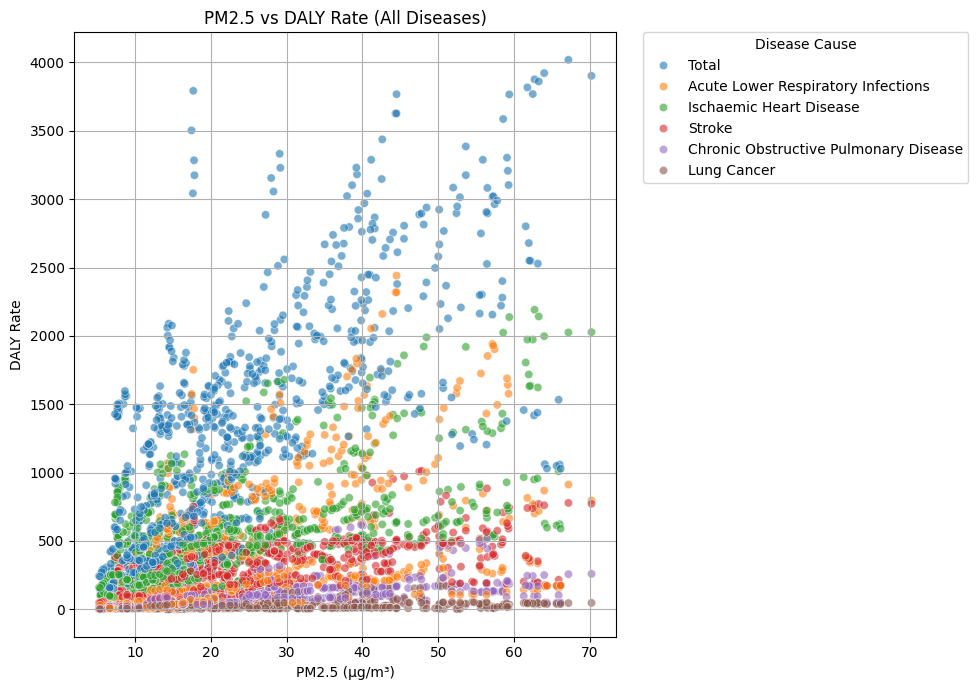

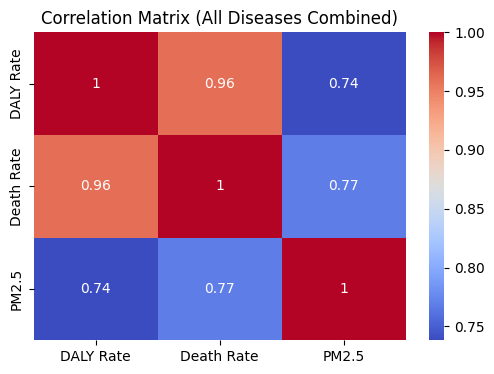

In [21]:

# SCATTERPLOT: PM2.5 vs DALY Rate (All Diseases)

plt.figure(figsize=(10, 7))
scatter = sns.scatterplot(
    data=merged_df,
    x="PM2.5",
    y="DALY Rate",
    hue="Cause",
    alpha=0.6,
    palette="tab10",
)

plt.title("PM2.5 vs DALY Rate (All Diseases)")
plt.xlabel("PM2.5 (μg/m³)")
plt.ylabel("DALY Rate")
plt.grid(True)

plt.legend(
    title="Disease Cause",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0,
    frameon=True
)
plt.tight_layout()
plt.show()


# CORRELATION HEATMAP (All Diseases Grouped)
grouped_all = merged_df.groupby(["Country", "Year"])[["DALY Rate", "Death Rate", "PM2.5"]].mean().reset_index()
plt.figure(figsize=(6, 4))
sns.heatmap(grouped_all[["DALY Rate", "Death Rate", "PM2.5"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix (All Diseases Combined)")
plt.show()


 **Interpretation:**

 This scatterplot shows a moderate upward trend, suggesting that as PM2.5 levels rise, the overall DALY(Disease Adjusted Life Years) rate across all diseases tends to increase. The spread is wide, so while there is some association, it may not be disease-specific.

 This correlation matrix shows a **strong positive relationship** between air pollution (PM2.5) and both health indicators:
 - **PM2.5 vs DALY Rate**: r = 0.74  
 - **PM2.5 vs Death Rate**: r = 0.77

This suggests that as air pollution increases, so do both the **overall disease burden (DALY)** and **mortality rates**, across all diseases combined. The **extremely high correlation** between DALY and Death Rate (r = 0.96) also confirms they track closely together, reflecting consistent patterns in the health impact of pollution.

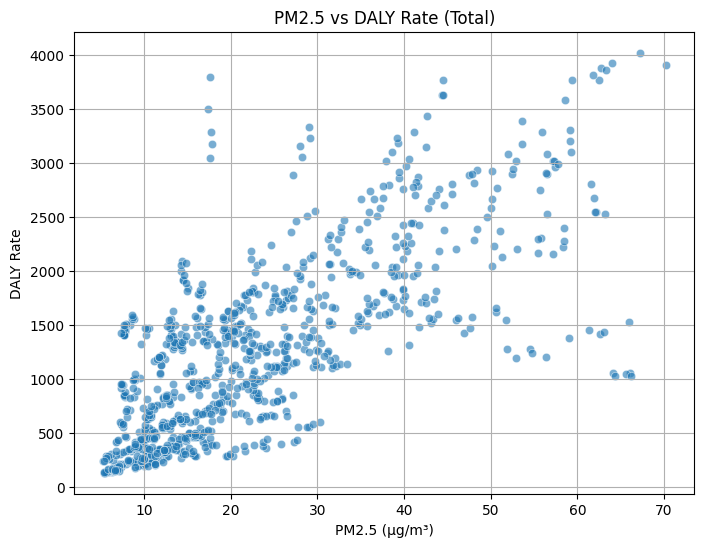

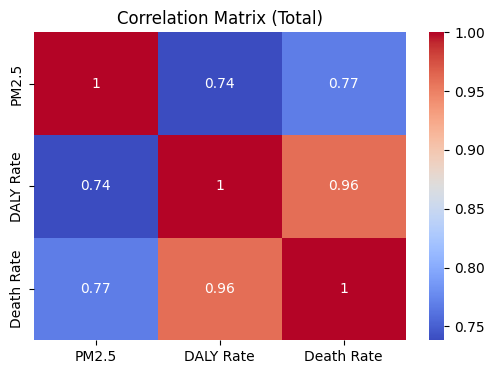

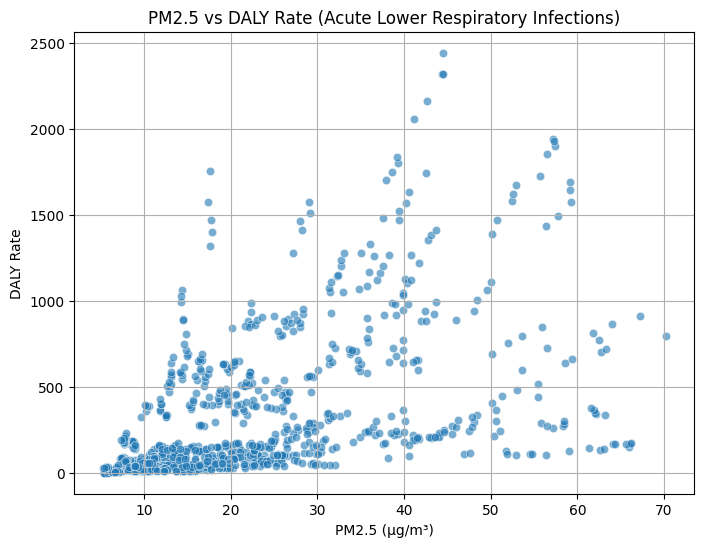

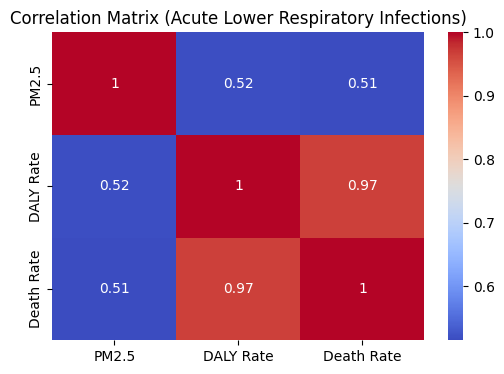

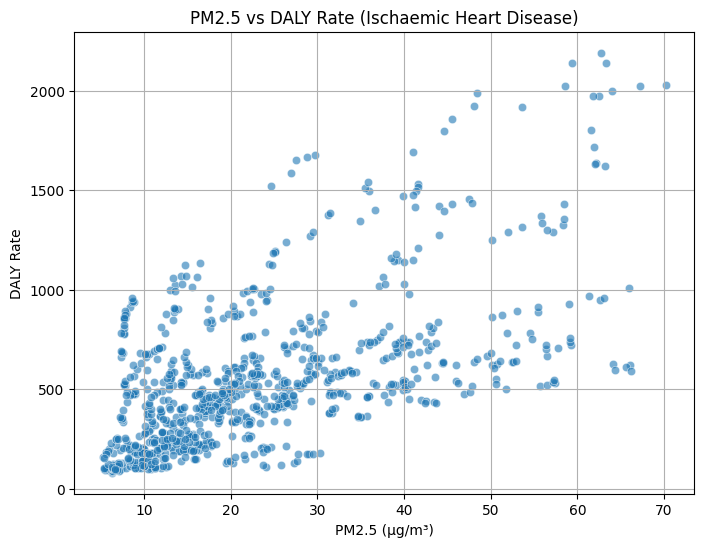

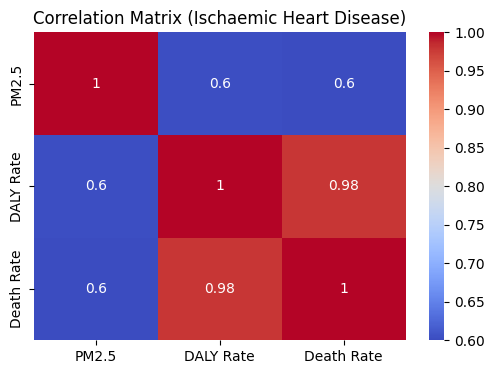

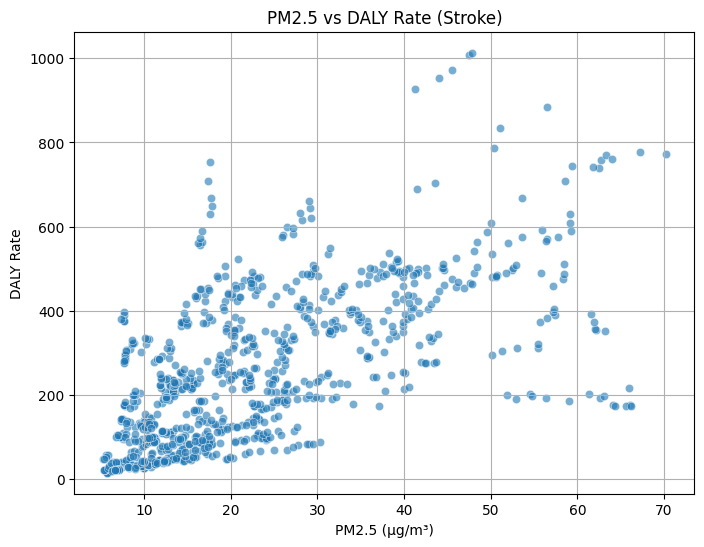

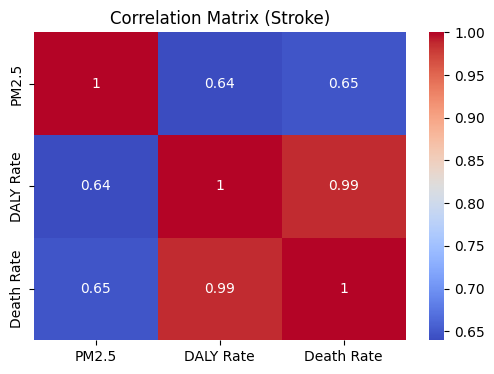

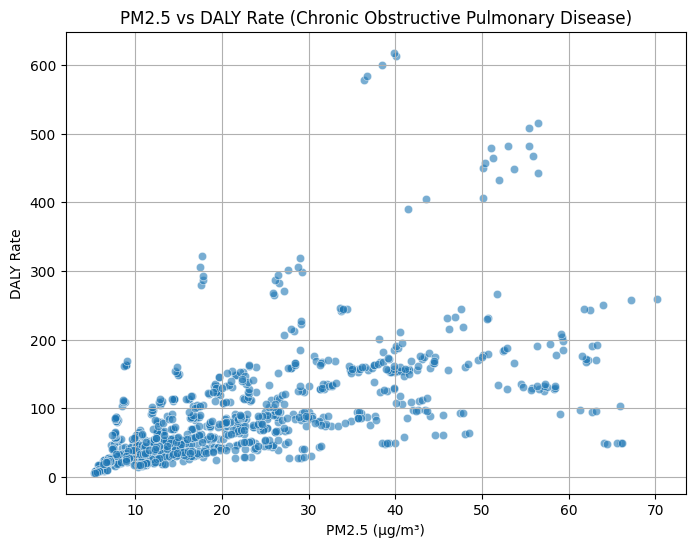

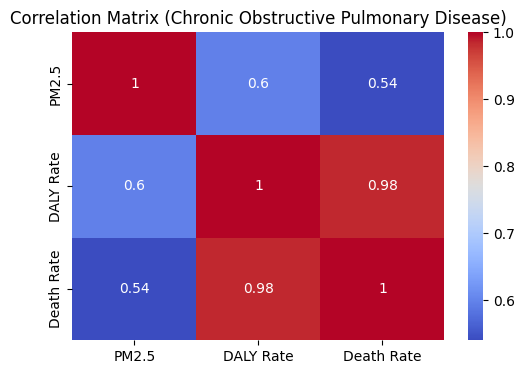

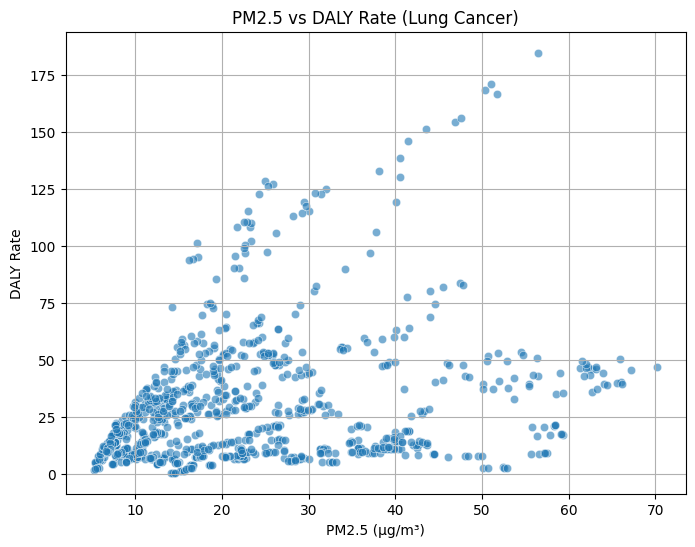

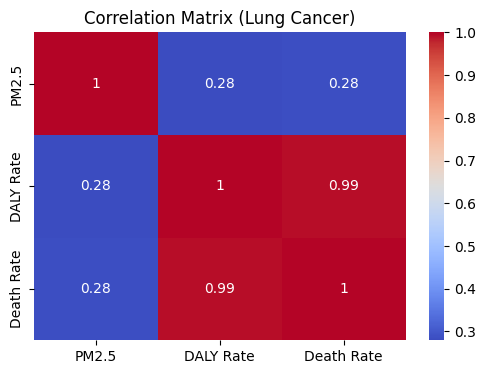

In [7]:
# Get all unique disease names
all_causes = merged_df["Cause"].unique()

# Loop through each disease and generate plots
for cause in all_causes:
    df_cause = merged_df[merged_df["Cause"] == cause]

    # Scatterplot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_cause, x="PM2.5", y="DALY Rate", alpha=0.6)
    plt.title(f"PM2.5 vs DALY Rate ({cause})")
    plt.xlabel("PM2.5 (μg/m³)")
    plt.ylabel("DALY Rate")
    plt.grid(True)
    plt.show()

    # Correlation matrix
    corr_cause = df_cause[["PM2.5", "DALY Rate", "Death Rate"]].dropna()
    plt.figure(figsize=(6, 4))
    sns.heatmap(corr_cause.corr(), annot=True, cmap="coolwarm")
    plt.title(f"Correlation Matrix ({cause})")
    plt.show()


### **Interpretation: Disease-Specific Impact of Air Pollution**

The diseases analyzed in the above plots were **specifically selected by the World Health Organization (WHO)** due to their established or suspected links to **air pollution**. These are not random illnesses — they represent health outcomes that have consistently appeared in global burden of disease assessments as **pollution-sensitive conditions**.

As expected, **respiratory diseases** — such as **acute lower respiratory infections** and **chronic obstructive pulmonary disease (COPD)** — show clear positive correlations with PM2.5 levels. This aligns with existing literature that directly associates airborne pollutants with damage to the respiratory tract.

What’s particularly notable is that **non-respiratory diseases**, especially **ischemic heart disease** and **stroke**, also show **strong correlations** with air pollution. These findings reinforce the emerging understanding that pollution is not only a respiratory hazard, but a **major cardiovascular risk factor**. Fine particulate matter can enter the bloodstream, promote inflammation, and contribute to plaque buildup in arteries, thereby increasing the risk of heart attacks and strokes.

In contrast, **lung cancer** shows a **weaker correlation** in this dataset. However, this does not necessarily indicate a lack of association. Cancer, particularly lung cancer, often involves a **long latency period** — meaning that the effects of pollution exposure today may not be reflected in cancer rates for many years. Additionally, lung cancer is influenced by **multiple risk factors**, such as tobacco use and occupational exposure, which may dilute the immediate visibility of pollution’s effect in global, cross-sectional data.



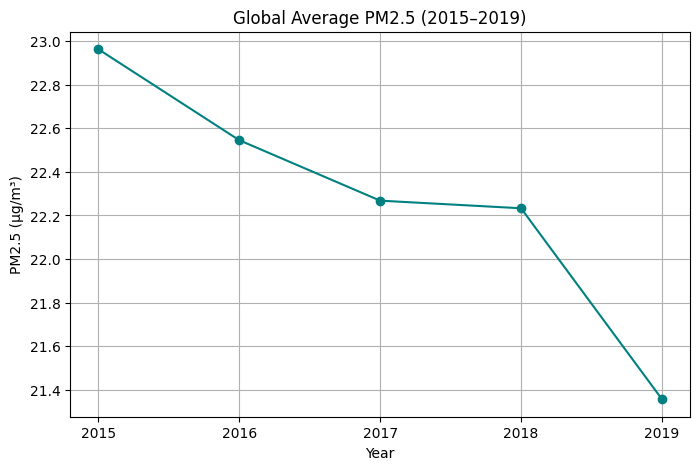

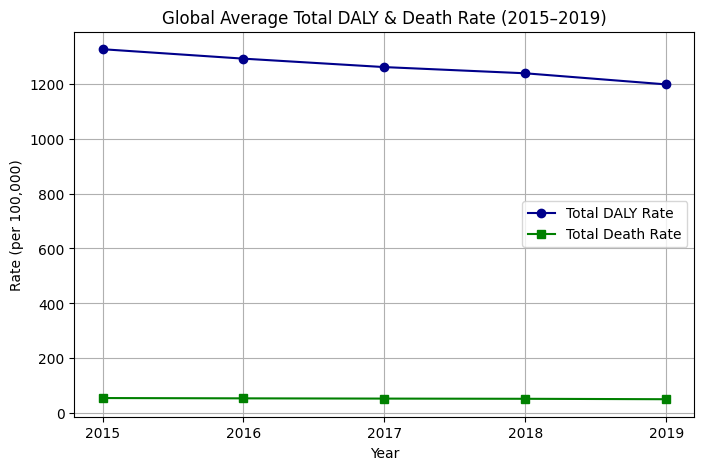

In [20]:
# === 1. Global Average PM2.5 per Year ===
avg_pm25_by_year = pollution_df.groupby("Year")["PM2.5"].mean()

plt.figure(figsize=(8, 5))
plt.plot(avg_pm25_by_year.index, avg_pm25_by_year.values, marker="o", color="teal")
plt.title("Global Average PM2.5 (2015–2019)")
plt.xlabel("Year")
plt.ylabel("PM2.5 (μg/m³)")
plt.xticks(avg_pm25_by_year.index.astype(int))
plt.grid(True)
plt.show()

# === 2. Global Total DALY & Death Rate per Year ===
total = merged_df[merged_df["Cause"] == "Total"]
total_trend = total.groupby("Year")[["DALY Rate", "Death Rate"]].mean()

plt.figure(figsize=(8, 5))
plt.plot(total_trend.index, total_trend["DALY Rate"], label="Total DALY Rate", marker="o", color="darkblue")
plt.plot(total_trend.index, total_trend["Death Rate"], label="Total Death Rate", marker="s", color="green")
plt.title("Global Average Total DALY & Death Rate (2015–2019)")
plt.xlabel("Year")
plt.ylabel("Rate (per 100,000)")
plt.xticks(total_trend.index.astype(int))
plt.legend()
plt.grid(True)
plt.show()


 **Interpretation:**

From 2015 to 2019, global average PM2.5 levels show a slight downward trend, likely reflecting the effects of environmental regulations, technological improvements, and increasing global focus on air quality management.

During the same period, both the total DALY rate and total death rate across all diseases show a modest decrease. The decline in DALY rates suggests improvements in overall health outcomes and quality of life — people may be living longer with fewer years lost to illness or disability.

However, the decrease in the total death rate appears smaller and more gradual, indicating that while quality of life and disease burden are improving, mortality itself remains relatively stable over short timescales like five years.

It’s important to recognize that these trends could be influenced by multiple overlapping factors — including healthcare access, vaccination programs, public health initiatives, and demographic shifts — in addition to air pollution control. Therefore, while the timing aligns with reductions in PM2.5, it is difficult to attribute the observed improvements solely to air pollution changes without deeper causal analysis.



In [9]:
# Filter WHO pollution-associated diseases (Cause = Total, Both sexes, All ages)
deaths_cleaned = deaths_df[
    (deaths_df["Sex"] == "Both") &
    (deaths_df["Age group"] == "All ages") &
    (deaths_df["GHE Cause"] == "Total")
].copy()

deaths_cleaned = deaths_cleaned.rename(columns={
    "Country/ territory/ area": "Country",
    "Age-standardized rate": "Pollution-Linked Disease Death Rate"
})[["Country", "Year", "Pollution-Linked Disease Death Rate"]]

# Rename new WHO dataset
new_deaths_renamed = alldeaths_df.rename(columns={
    "New Age-Standardized Death Rate": "Total All-Cause Death Rate"
})

# Merge the two death sources
death_merged = pd.merge(deaths_cleaned, new_deaths_renamed, on=["Country", "Year"], how="inner")

# Merge with PM2.5 air pollution data
full_df = pd.merge(death_merged, pollution_df, on=["Country", "Year"], how="inner")

# Compute ratio
full_df["Proportional Burden of Pollution-Linked Diseases"] = (
    full_df["Pollution-Linked Disease Death Rate"] / full_df["Total All-Cause Death Rate"]
)

full_df = full_df[full_df["Proportional Burden of Pollution-Linked Diseases"] <= 1]


print(full_df.head())



               Country  Year  Pollution-Linked Disease Death Rate  Unnamed: 0  \
0  Antigua and Barbuda  2019                               19.279         739   
1  Antigua and Barbuda  2018                               20.366        2157   
2  Antigua and Barbuda  2017                               20.505         959   
3  Antigua and Barbuda  2016                               20.564         899   
4  Antigua and Barbuda  2015                               20.957         983   

   Total All-Cause Death Rate  PM2.5  \
0                  636.339299   8.30   
1                  587.832084   8.87   
2                  589.985958   9.27   
3                  573.381150   8.95   
4                  564.307548   8.89   

   Proportional Burden of Pollution-Linked Diseases  
0                                          0.030297  
1                                          0.034646  
2                                          0.034755  
3                                          0.035864  
4 

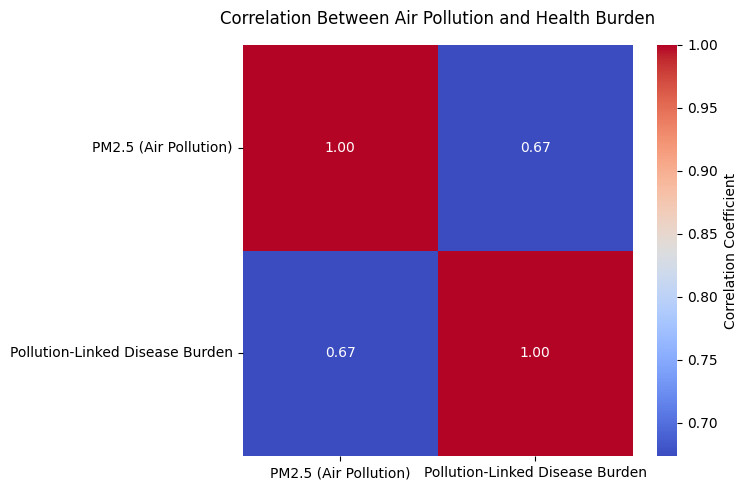

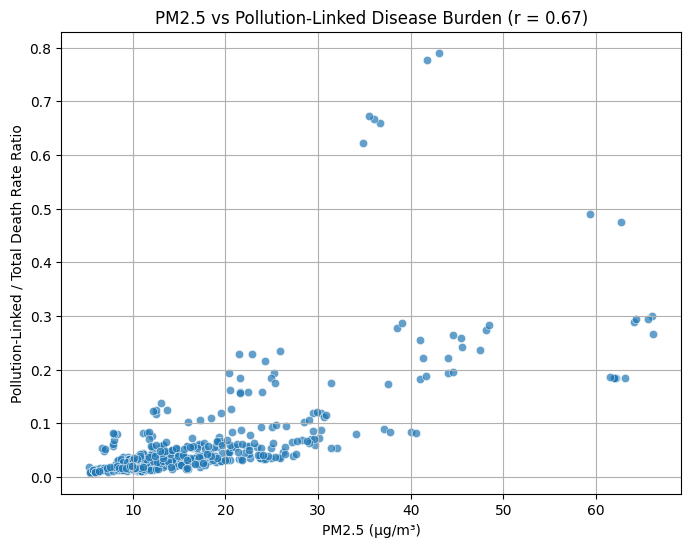

Correlation Coefficient (r): 0.6732


In [10]:
# Correlation and visualization
corr = full_df[["PM2.5", "Proportional Burden of Pollution-Linked Diseases"]].corr().iloc[0, 1]

plt.figure(figsize=(7.5, 5))
sns.heatmap(
    full_df[["PM2.5", "Proportional Burden of Pollution-Linked Diseases"]].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.xticks(
    [0.5, 1.5],
    ["PM2.5 (Air Pollution)", "Pollution-Linked Disease Burden"],
    rotation=0
)
plt.yticks(
    [0.5, 1.5],
    ["PM2.5 (Air Pollution)", "Pollution-Linked Disease Burden"],
    rotation=0
)
plt.title("Correlation Between Air Pollution and Health Burden", pad=15)
plt.tight_layout()
plt.show()

# Plot scatter
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=full_df,
    x="PM2.5",
    y="Proportional Burden of Pollution-Linked Diseases",
    alpha=0.7
)
plt.title(f"PM2.5 vs Pollution-Linked Disease Burden (r = {corr:.2f})")
plt.xlabel("PM2.5 (μg/m³)")
plt.ylabel("Pollution-Linked / Total Death Rate Ratio")
plt.grid(True)
plt.show()

print(f"Correlation Coefficient (r): {corr:.4f}")

### **Interpretation: Correlation Between Air Pollution and Pollution-Linked Disease Burden**

This heatmap displays the correlation between **PM2.5 levels** (fine particulate matter in the air) and the **proportional burden of pollution-linked diseases** across countries.

- **PM2.5 (Air Pollution)**: Measured in μg/m³, represents ambient air pollution levels.
- **Pollution-Linked Disease Burden**: Computed as the ratio of deaths from diseases WHO has associated with air pollution (e.g., respiratory, cardiovascular) to total all-cause death rates per 100,000 population.

#### **Key Result: r = 0.68**
- This means there is a **strong positive correlation** between air pollution and the proportion of deaths caused by pollution-linked diseases.
- In other words, in countries with **higher PM2.5 levels**, a **greater share of deaths** is attributed to diseases that are known to be impacted by air pollution.
- The correlation coefficient (r) ranges from -1 to +1:
  - **r = 0.68** suggests a meaningful upward trend, not random, and not weak.
  - It’s not perfect, but **strong enough** to indicate a pattern that likely reflects a **real-world causal link** (especially since these are WHO-selected diseases).

#### **Implications:**
- This supports the idea that **air pollution is not just an environmental issue**, but a major contributor to **health disparities** and **mortality structure** across countries.
- It also validates using the pollution-linked death subset as a meaningful health indicator when tracking environmental risk.


#Hypothesis Testing

### 1st Hypothesis Formulation
####Is there a monotonic relationship between PM2.5 concentration and the total DALY rate per 100,000 population?


**Null Hypothesis (H₀):**  
There is no significant difference in DALY (Disability-Adjusted Life Year) rates between countries with high and low PM2.5 air pollution levels.

**Alternative Hypothesis (H₁):**  
Countries with higher PM2.5 air pollution levels have significantly higher DALY rates compared to countries with lower PM2.5 levels.


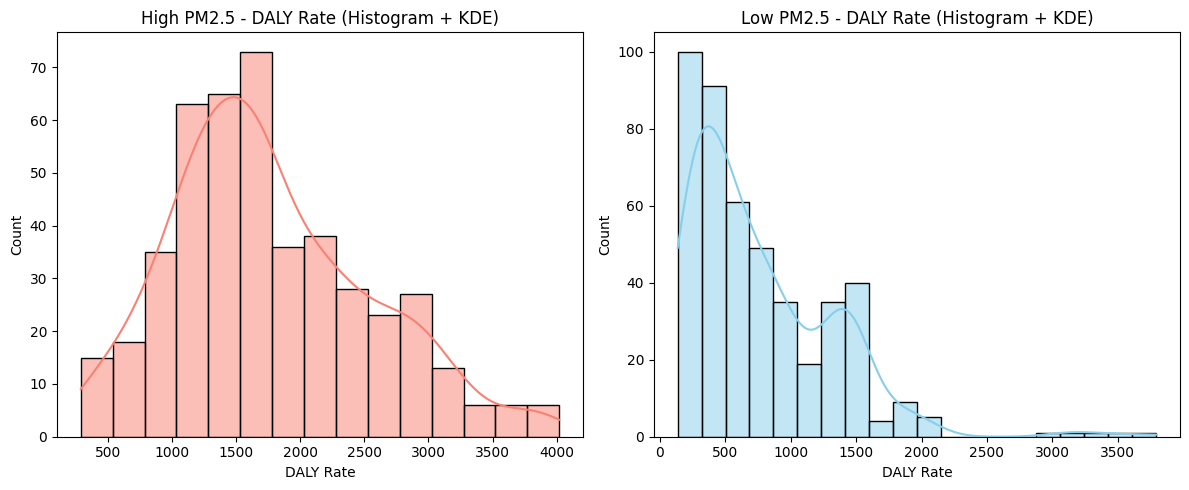

In [11]:

# Filter for "Total" DALY Rate only
total_daly_df = merged_df[merged_df["Cause"] == "Total"].copy()

# Split by median PM2.5
pm25_median = total_daly_df["PM2.5"].median()
high_group = total_daly_df[total_daly_df["PM2.5"] > pm25_median]["DALY Rate"]
low_group = total_daly_df[total_daly_df["PM2.5"] <= pm25_median]["DALY Rate"]

plt.figure(figsize=(12, 5))

# High PM2.5
plt.subplot(1, 2, 1)
sns.histplot(high_group, kde=True, color="salmon", edgecolor="black")
plt.title("High PM2.5 - DALY Rate (Histogram + KDE)")
plt.xlabel("DALY Rate")

# Low PM2.5
plt.subplot(1, 2, 2)
sns.histplot(low_group, kde=True, color="skyblue", edgecolor="black")
plt.title("Low PM2.5 - DALY Rate (Histogram + KDE)")
plt.xlabel("DALY Rate")

plt.tight_layout()
plt.show()


Countries are divided into high and low air pollution groups based on the median PM2.5 level. Then, their DALY rates are visualized using histograms and KDEs. The high pollution group showed a noticeably higher distribution of DALY rates, suggesting that countries with worse air pollution tend to face greater overall health burdens. This aligns with our hypothesis that pollution increases disease impact. Also by looking at the KDE lines it can be concluded that normal distribution cannot be assumed.

####Mann-Whitney U Test: PM2.5 vs Total DALY Rate

This non-parametric test compares DALY rates between countries with high and low air pollution.  
It tests whether countries with **higher PM2.5** levels tend to have **significantly higher DALY rates**.


In [12]:
from scipy.stats import mannwhitneyu

# Run Mann-Whitney U test
u_stat, p_val = mannwhitneyu(high_group, low_group, alternative="greater")

# Print results
print("=== Hypothesis Test: PM2.5 vs Total DALY Rate ===")
print(f"U statistic = {u_stat:.2f}")
print(f"p-value = {p_val:.4f}")
if p_val < 0.05:
    print("Statistically significant: High-PM2.5 countries have higher total DALY rates.")
else:
    print("Not statistically significant.")


=== Hypothesis Test: PM2.5 vs Total DALY Rate ===
U statistic = 177114.00
p-value = 0.0000
Statistically significant: High-PM2.5 countries have higher total DALY rates.


####Interpretation:

The Mann-Whitney U test was used to compare total DALY rates between countries with high and low levels of PM2.5 air pollution. Since the data did not meet the assumptions of normality, a non-parametric test was selected to ensure statistical validity.

The resulting **U statistic = 177114.00** and **p-value < 0.0001** indicate a statistically significant difference between the two groups. Specifically, countries with higher air pollution levels tend to exhibit **significantly higher total disease burdens**, as measured by DALY rates.

The **U statistic** itself reflects the number of times a value from one group is ranked higher than a value from the other group. A higher U statistic (in the "greater" direction) supports the hypothesis that values in the high-PM2.5 group tend to be greater than those in the low-PM2.5 group.

These results reinforce the finding that **air pollution is strongly associated with increased public health burdens at a population level**.

**Conclusion:**  
The visualization clearly shows that DALY rates are generally higher in countries with elevated PM2.5 levels. Combined with the statistically significant result from the Mann-Whitney U test (p < 0.05), we reject the null hypothesis (H₀). This supports the conclusion that higher air pollution is associated with greater total disease burden across countries.



###2nd Hypothesis Formulation:
####Is there a monotonic relationship between PM2.5 concentration and the absolute age-standardized death rate caused by pollution-linked diseases (per 100,000 population)?

- **Null Hypothesis (H₀):** There is no monotonic association between PM2.5 levels and age-standardized death rates attributable to pollution-related illnesses.
- **Alternative Hypothesis (H₁):** There is a positive monotonic association — higher PM2.5 levels are associated with higher age-standardized death rates from diseases linked to air pollution.

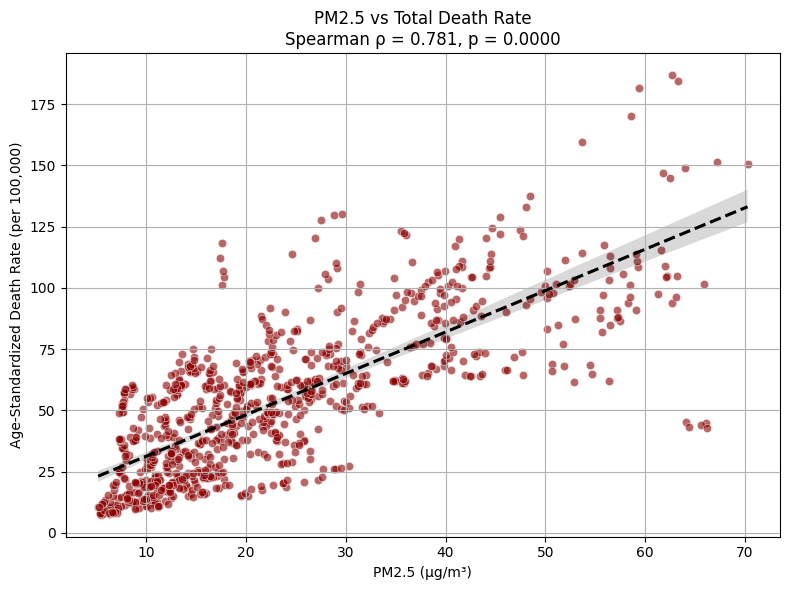

In [13]:

from scipy.stats import spearmanr

# Filter for total deaths
total_death_df = merged_df[merged_df["Cause"] == "Total"]

# Calculate Spearman correlation
rho, p_val = spearmanr(total_death_df["PM2.5"], total_death_df["Death Rate"])

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=total_death_df, x="PM2.5", y="Death Rate", color="darkred", alpha=0.6)
sns.regplot(data=total_death_df, x="PM2.5", y="Death Rate", scatter=False, color="black", line_kws={"linestyle": "dashed"})

# Annotate with stats
plt.title(f"PM2.5 vs Total Death Rate\nSpearman ρ = {rho:.3f}, p = {p_val:.4f}")
plt.xlabel("PM2.5 (μg/m³)")
plt.ylabel("Age-Standardized Death Rate (per 100,000)")
plt.grid(True)
plt.tight_layout()
plt.show()


To evaluate the relationship between air pollution and total mortality, a Spearman rank correlation test was conducted. This non-parametric method is suitable for data that do not follow a normal distribution and captures monotonic trends rather than strictly linear ones.

The scatter plot above shows the relationship between PM2.5 concentrations and total age-standardized death rates attributable to pollution-related illnesses. Each point represents a country-year pair. The Spearman correlation coefficient was calculated as **ρ = 0.781** with a p-value of **0.0000**, indicating a strong and statistically significant positive association.


**Conclusion:**  
Since the p-value is far below the 0.05 threshold, we **reject the null hypothesis (H₀)**.  
There is a statistically significant and strong positive association between air pollution levels and total death rates.



###3rd Hypothesis Formulation:
####Is there a monotonic relationship between PM2.5 concentration and the proportion of total deaths attributable to pollution-linked diseases?

- **Null Hypothesis (H₀):** There is no monotonic relationship between PM2.5 air pollution and the proportion of deaths caused by pollution-linked diseases out of total number of deaths.
- **Alternative Hypothesis (H₁):** There is a positive monotonic relationship — as PM2.5 levels increase, the proportion of deaths due to pollution-linked diseases out of total number of deaths also increases.


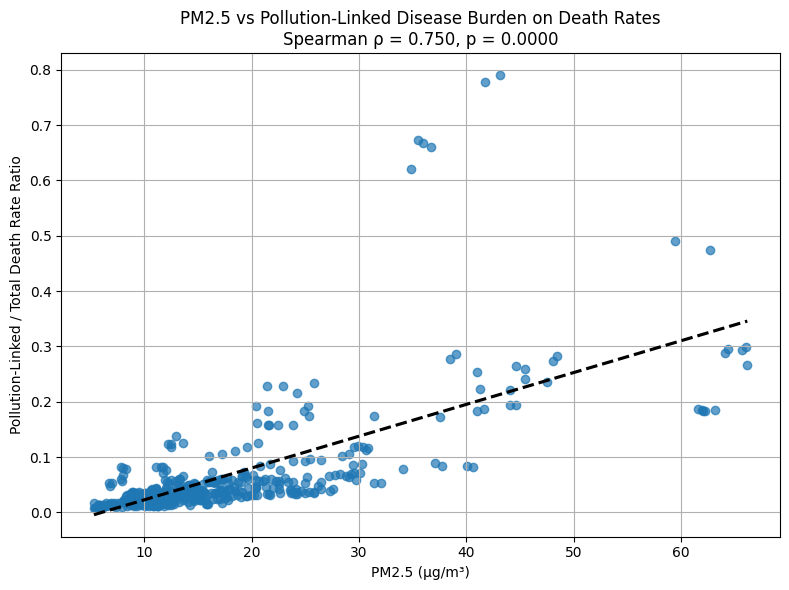

In [14]:

# Spearman correlation
rho, pval = spearmanr(full_df["PM2.5"], full_df["Proportional Burden of Pollution-Linked Diseases"])

# Scatterplot with correlation annotation and regression line
plt.figure(figsize=(8, 6))
sns.regplot(
    data=full_df,
    x="PM2.5",
    y="Proportional Burden of Pollution-Linked Diseases",
    scatter_kws={"alpha": 0.7},
    line_kws={"color": "black", "linestyle": "dashed"},
    ci=None
)
plt.title(f"PM2.5 vs Pollution-Linked Disease Burden on Death Rates\nSpearman ρ = {rho:.3f}, p = {pval:.4f}")
plt.xlabel("PM2.5 (μg/m³)")
plt.ylabel("Pollution-Linked / Total Death Rate Ratio")
plt.grid(True)
plt.tight_layout()
plt.show()


- **Spearman Correlation Coefficient (ρ):** 0.750
- **p-value:** 0.0000

 The correlation is strong and statistically significant. This indicates that countries with higher PM2.5 levels tend to have a greater share of total deaths attributed to pollution-linked diseases.

 **Conclusion:**

 Since the p-value is far below the 0.05 threshold, we reject the null hypothesis (H₀).
There is evidence of a statistically significant positive monotonic relationship between air pollution and the death burden caused by pollution-linked diseases.



###4th Hypothesis Formulation
####Do countries with higher PM2.5 values experienced different levels of improvement in DALY rate over time?

**Null Hypothesis (H₀):** There is no monotonic relationship between average PM2.5 levels and the change in total DALY rates from 2015 to 2019.

**Alternative Hypothesis (H₁):** There is a significant monotonic relationship between average PM2.5 and the change in DALY rates.  


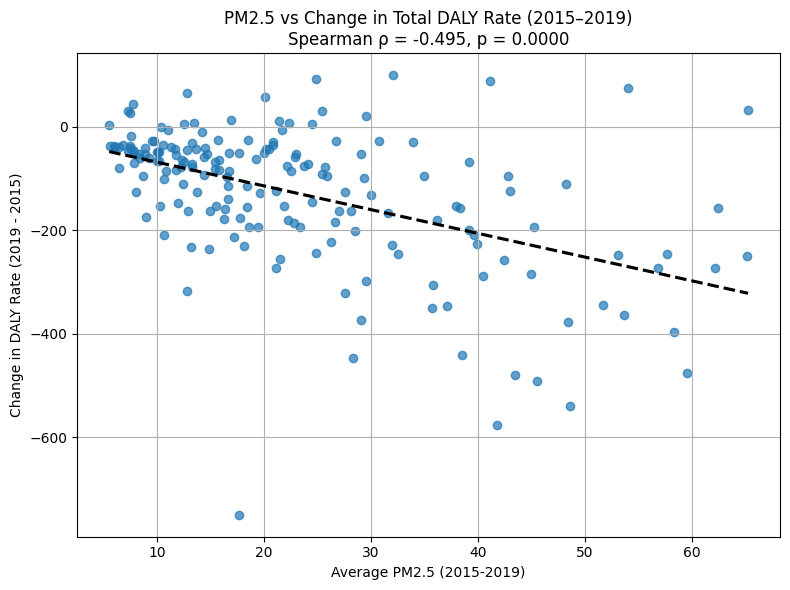

Spearman Correlation: ρ = -0.4952, p = 0.0000


In [16]:

# Filter 'Total' DALY entries only
total_daly = merged_df[merged_df["Cause"] == "Total"].copy()

# Pivot to get DALY Rate for 2015 and 2019 side-by-side
daly_pivot = total_daly.pivot_table(index="Country", columns="Year", values="DALY Rate")

# Keep only countries that have both 2015 and 2019 data
daly_pivot = daly_pivot[[2015, 2019]].dropna()

# Calculate DALY change
daly_pivot["DALY Change"] = daly_pivot[2019] - daly_pivot[2015]

# Calculate average PM2.5 per country
avg_pm25 = merged_df.groupby("Country")["PM2.5"].mean()

# Merge the two
daly_change_df = daly_pivot.merge(avg_pm25, on="Country")

# Spearman Correlation Test
rho, pval = spearmanr(daly_change_df["PM2.5"], daly_change_df["DALY Change"])

# Plotting
plt.figure(figsize=(8,6))
sns.regplot(data=daly_change_df, x="PM2.5", y="DALY Change", scatter_kws={"alpha":0.7}, line_kws={"color":"black", "linestyle":"dashed"}, ci=None)
plt.title(f"PM2.5 vs Change in Total DALY Rate (2015–2019)\nSpearman ρ = {rho:.3f}, p = {pval:.4f}")
plt.xlabel("Average PM2.5 (2015-2019)")
plt.ylabel("Change in DALY Rate (2019 - 2015)")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Spearman Correlation: ρ = {rho:.4f}, p = {pval:.4f}")


Spearman’s rank correlation coefficient was computed between average PM2.5 levels (2015–2019) and the change in total DALY rate (2019 minus 2015).

**Result:**
- ρ = –0.4952  
- p = 0.0000

The negative correlation indicates that **countries with higher pollution levels tended to show larger decreases in DALY rates** over the 5-year span.

This does **not** mean that high-pollution is beneficial — instead, it likely reflects that:
- These countries had **very high DALY rates to begin with**, giving them **greater opportunity for reduction**.
- Countries with **already low pollution and DALY rates** remained relatively **stable**, showing less change.

**Conclusion:**

Since p < 0.05, we reject the null hypothesis. There is statistically significant evidence of a **monotonic relationship** between PM2.5 levels and the change in DALY rate. The **negative ρ** suggests that high-pollution countries improved more, likely due to high initial DALY burdens and potential health interventions during the period.




###5th Hypothesis Formulation
####Is there a monotonic relationship between long-term average PM2.5 concentration and the change in total age-standardized death rates over time?

- **Null Hypothesis (H₀):** There is no monotonic relationship between PM2.5 air pollution and the change in total death rates between 2015 and 2019.
- **Alternative Hypothesis (H₁):** There is a monotonic relationship — specifically, as PM2.5 levels increase, the change in total death rates also significantly differs (either increasing or decreasing).



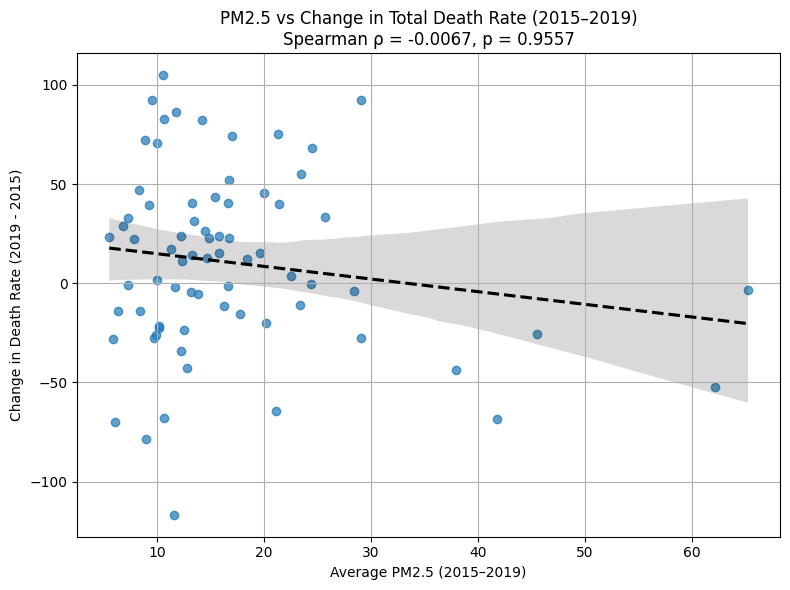

Spearman Correlation: ρ = -0.0067, p = 0.9557


In [17]:

# Get 2015 and 2019 pollution and death data
death_2015 = full_df[full_df["Year"] == 2015][["Country", "Total All-Cause Death Rate"]].rename(columns={"Total All-Cause Death Rate": "Death_2015"})
death_2019 = full_df[full_df["Year"] == 2019][["Country", "Total All-Cause Death Rate"]].rename(columns={"Total All-Cause Death Rate": "Death_2019"})

# Merge and calculate change
death_change_df = pd.merge(death_2015, death_2019, on="Country", how="inner")
death_change_df["Change in Death Rate"] = death_change_df["Death_2019"] - death_change_df["Death_2015"]

# Add average PM2.5 for same countries
avg_pm25 = full_df.groupby("Country")["PM2.5"].mean().reset_index().rename(columns={"PM2.5": "Avg_PM2.5"})
death_change_df = pd.merge(death_change_df, avg_pm25, on="Country", how="inner")

# Spearman correlation
rho, pval = spearmanr(death_change_df["Avg_PM2.5"], death_change_df["Change in Death Rate"])

# Plot
plt.figure(figsize=(8, 6))
sns.regplot(
    x="Avg_PM2.5",
    y="Change in Death Rate",
    data=death_change_df,
    scatter_kws={"alpha": 0.7},
    line_kws={"linestyle": "dashed", "color": "black"},
)
plt.title(f"PM2.5 vs Change in Total Death Rate (2015–2019)\nSpearman ρ = {rho:.4f}, p = {pval:.4f}")
plt.xlabel("Average PM2.5 (2015–2019)")
plt.ylabel("Change in Death Rate (2019 - 2015)")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Spearman Correlation: ρ = {rho:.4f}, p = {pval:.4f}")


The Spearman correlation result indicates that there is essentially **no monotonic relationship** between average PM2.5 levels and the change in death rates from 2015 to 2019. The coefficient is extremely close to zero, and the high p-value confirms that this observation is **not statistically significant**.

This suggests that **air pollution does not appear to be associated with a meaningful shift (increase or decrease) in total death rates over this 5-year period.**

**Conclusion:**

Fail to reject the null hypothesis since p > 0.05  
There is **no significant relationship** between air pollution levels and change in overall death rates between 2015 and 2019.

###Cross-Validation with Global Trends

The results from Hypotheses 4 and 5 are consistent with the observed patterns in the plot titled **"Global Average Total DALY & Death Rate (2015–2019)"**.  
In the graph, the **DALY rate** shows a clear downward trend over the years, whereas the **death rate** remains relatively stable.  
This visual evidence supports the statistical findings: while overall disease burden (DALYs) improved during the period, total mortality rates did not change as significantly.


###6th Hypothesis Formation
####Is there a monotonic relationship between PM2.5 concentration and the change in proportional burden of pollution-linked deaths over time (2019–2015)?

- Null Hypothesis (H₀): There is no monotonic relationship between PM2.5 levels and the change in the proportion of pollution-linked deaths.
- Alternative Hypothesis (H₁): There is a negative monotonic relationship—as PM2.5 increases, the burden of pollution-linked deaths has decreased more over time.

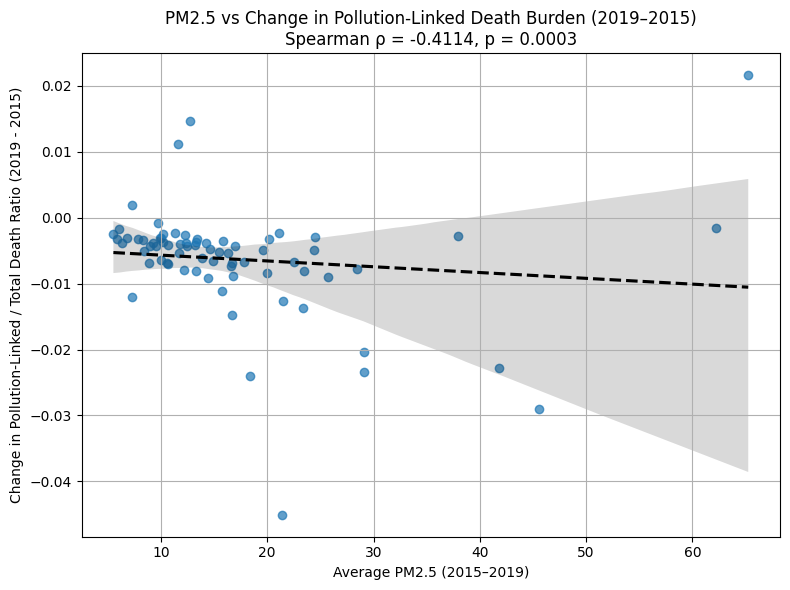

Spearman Correlation: ρ = -0.4114, p = 0.0003


In [19]:
# Average PM2.5 for each country (2015–2019)
avg_pm25 = full_df.groupby("Country")["PM2.5"].mean().reset_index()
avg_pm25.rename(columns={"PM2.5": "Average PM2.5"}, inplace=True)

# Pollution-linked burden in 2015 and 2019
burden_2015 = full_df[full_df["Year"] == 2015][["Country", "Proportional Burden of Pollution-Linked Diseases"]]
burden_2019 = full_df[full_df["Year"] == 2019][["Country", "Proportional Burden of Pollution-Linked Diseases"]]

# Rename columns for clarity
burden_2015.rename(columns={"Proportional Burden of Pollution-Linked Diseases": "Burden 2015"}, inplace=True)
burden_2019.rename(columns={"Proportional Burden of Pollution-Linked Diseases": "Burden 2019"}, inplace=True)

# Merge and compute change
burden_change = pd.merge(burden_2015, burden_2019, on="Country", how="inner")
burden_change["Burden Change (2019 - 2015)"] = burden_change["Burden 2019"] - burden_change["Burden 2015"]

# Merge with PM2.5
merged_final = pd.merge(avg_pm25, burden_change, on="Country", how="inner")

# Spearman correlation
from scipy.stats import spearmanr
rho, pval = spearmanr(merged_final["Average PM2.5"], merged_final["Burden Change (2019 - 2015)"])

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.regplot(
    x="Average PM2.5",
    y="Burden Change (2019 - 2015)",
    data=merged_final,
    scatter_kws={"alpha": 0.7},
    line_kws={"linestyle": "dashed", "color": "black"},
)
plt.title(f"PM2.5 vs Change in Pollution-Linked Death Burden (2019–2015)\nSpearman ρ = {rho:.4f}, p = {pval:.4f}")
plt.xlabel("Average PM2.5 (2015–2019)")
plt.ylabel("Change in Pollution-Linked / Total Death Ratio (2019 - 2015)")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Spearman Correlation: ρ = {rho:.4f}, p = {pval:.4f}")


This analysis examines the **change in the proportion** of deaths attributed to pollution-linked diseases from 2015 to 2019, and how that change relates to average PM2.5 exposure across countries. The result showed a moderate negative correlation (Spearman ρ = –0.4114, p = 0.0003), indicating that **higher-PM2.5 countries** tended to experience **greater reductions** in the share of deaths caused by pollution-linked illnesses.

This could suggest that in highly polluted countries, **public health interventions, awareness, or broader healthcare improvements** during this period were more impactful in addressing pollution-linked disease burdens. On the other hand, countries with already low pollution may have had **less room for proportional improvement.**

By focusing on **proportions rather than raw death rates** (hypothesis 5 focused on raw death rates), this test controls for overall mortality trends and highlights how the **relative weight of pollution-linked causes shifted over time.**

**Conclusion:**

Since the p-value is below 0.05, the **null hypothesis is rejected**.  
There is a statistically significant **negative monotonic relationship** between PM2.5 levels and the change in proportional pollution-linked death burden from 2015 to 2019.
